In [ ]:
# df_q['Annual Income'] = df_q['Annual Income'].interpolate(method='linear')

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

## Paths to directories and files 

In [69]:
from pathlib import Path

DATA_ROOT = Path('./data/training_project/')
MODELS_PATH = Path('./models/')

# input
DATASET_PATH = DATA_ROOT / 'train.csv'
TEST_DATASET_PATH = DATA_ROOT / 'test.csv'

PREP_DATASET_PATH = DATA_ROOT / 'training_project_data_prep.csv'
PREP_TEST_DATASET_PATH = DATA_ROOT / 'final_project_data_prep.csv'


# output
TRAIN_FULL_PATH = DATA_ROOT / 'training_project_train_full.csv'
FINAL_FULL_PATH = DATA_ROOT / 'final_norm_full.csv'
TRAIN_PART_PATH = DATA_ROOT / 'training_project_train_part_b.csv'
TEST_PART_PATH = DATA_ROOT / 'training_project_test_part.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

## Loading prepared datasets

### Loading data

In [9]:
df_base = pd.read_csv(DATASET_PATH)

df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

### Isolation of the indicative description and the target variable

In [10]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop([TARGET_NAME,'Months since last delinquent']).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

NUM_FEATURE_NAMES = ['Annual Income','Number of Open Accounts','Years of Credit History',\
       'Maximum Open Credit','Number of Credit Problems','Current Loan Amount','Years in current job',\
                     'Current Credit Balance', 'Monthly Debt','Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership','Tax Liens','Bankruptcies', 'Purpose','Term']
CAT_FEATURE_NAMES_U = ['Bankruptcies']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES_U + NEW_FEATURE_NAMES

In [11]:
X = df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y = df[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME])
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=[TARGET_NAME])
y_test = df_test[TARGET_NAME]

In [12]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ffb4bb75430>
Traceback (most recent call last):
  File "/home/recpi/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/recpi/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/recpi/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/recpi/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


1    3771
0    3771
Name: Credit Default, dtype: int64

In [13]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

## Filling gaps/outliers through the model

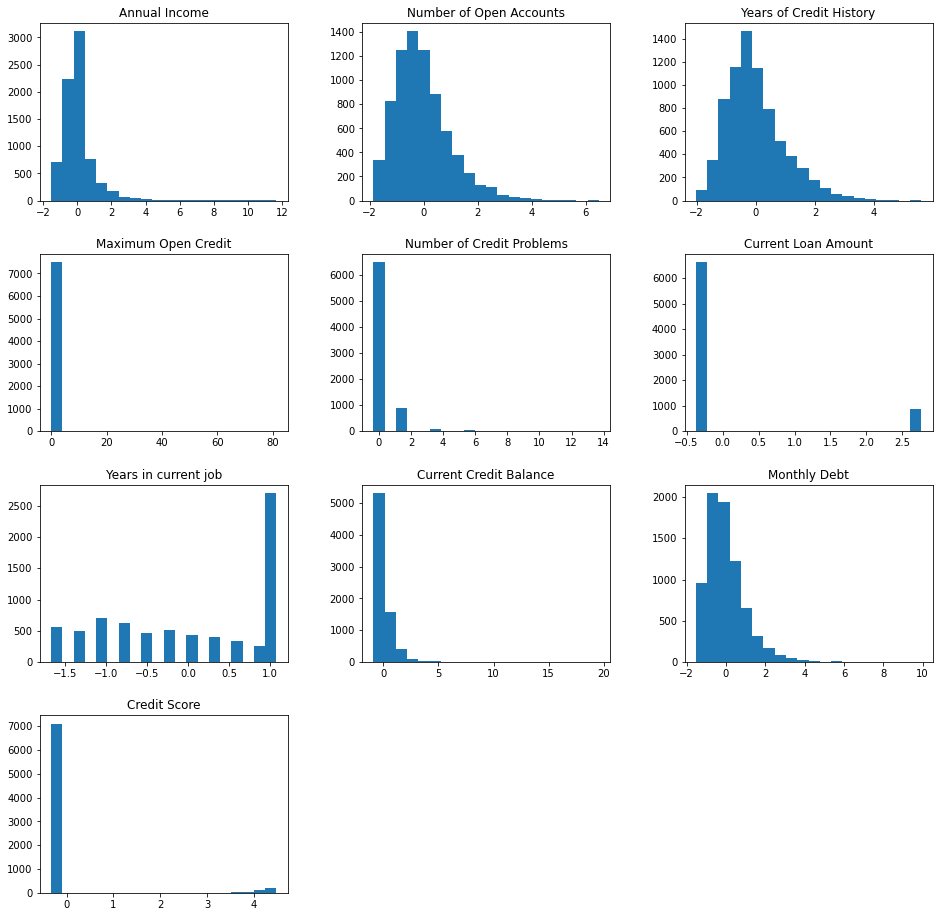

In [14]:
df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

In [15]:
df_copy = df.copy()
df_test_copy = df_test.copy()

In [16]:
df_copy.isna().sum().sum()

0

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=5,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

### 'Annual Income'

In [18]:
def preprocess_outlier(df, col, threshold):
    # can be cut by threshold, or by quantiles
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'Annual Income'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=3)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=3)

df_copy[feature_name].isna().sum()

137

In [19]:
%%time
bill_amt1_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.47181950041606113
r2 на test: 0.4530558301549039
CPU times: user 21.6 s, sys: 29.3 ms, total: 21.7 s
Wall time: 21.7 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [20]:
df_copy[feature_name].isna().sum()

0

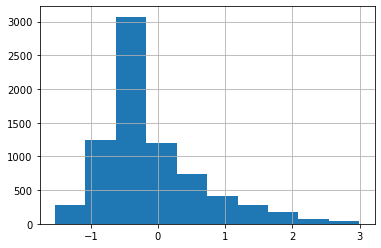

In [21]:
df_copy[feature_name].hist();

### 'Monthly Debt'

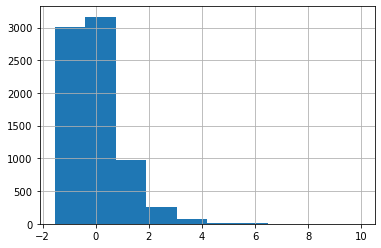

In [22]:
feature_name = 'Monthly Debt'
df_copy[feature_name].hist();

In [23]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=4)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=4)

df_copy[feature_name].isna().sum()

37

In [24]:
monthly_debt_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.5338783307135879
r2 на test: 0.48475521593725845


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [25]:
df_copy[feature_name].isna().sum()

0

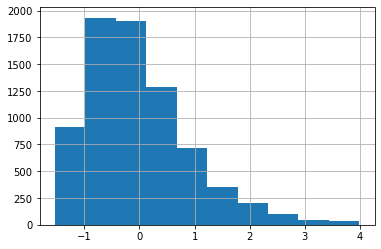

In [26]:
df_copy[feature_name].hist();

### 'Current Credit Balance'

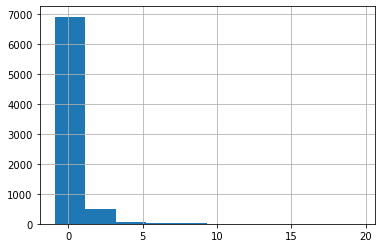

In [27]:
feature_name = 'Current Credit Balance'
df_copy[feature_name].hist();

In [28]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=3)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=3)

df_copy[feature_name].isna().sum()

110

In [29]:
current_credit_balance_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.7101412941236216
r2 на test: 0.6894162647843101


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [30]:
df_copy[feature_name].isna().sum()

0

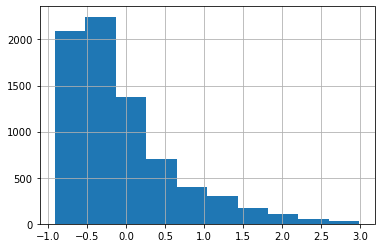

In [31]:
df_copy[feature_name].hist();

## Regularization

### Logistic Regression

In [32]:
model_lr = LogisticRegression(C=0.01,
                              max_iter=10
                              )
model_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)
model_lr.intercept_, model_lr.coef_.mean()

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.74      0.70      3771
           1       0.71      0.63      0.67      3771

    accuracy                           0.69      7542
   macro avg       0.69      0.69      0.69      7542
weighted avg       0.69      0.69      0.69      7542

TEST

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1616
           1       0.46      0.59      0.52       634

    accuracy                           0.69      2250
   macro avg       0.64      0.66      0.64      2250
weighted avg       0.72      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1178  438
1                261  373


(array([0.43231718]), -0.09906019382811816)

In [33]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [34]:
%%time
model_lr_cv = LogisticRegressionCV(max_iter=4,
                                   scoring='f1_macro',
                                   cv=cv, Cs=[0.001,0.01,0.1], #[0.001,0.01,0.1]
                                   )
model_lr_cv.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr_cv, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      3771
           1       0.71      0.66      0.68      3771

    accuracy                           0.69      7542
   macro avg       0.69      0.69      0.69      7542
weighted avg       0.69      0.69      0.69      7542

TEST

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1616
           1       0.45      0.61      0.52       634

    accuracy                           0.68      2250
   macro avg       0.63      0.66      0.64      2250
weighted avg       0.72      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1143  473
1                250  384
CPU times: user 666 ms, sys: 1.19 s, total: 1.86 s
Wall time: 292 ms


In [35]:
model_lr_cv.Cs_

array([0.001, 0.01 , 0.1  ])

In [36]:
model_lr_cv.C_

array([0.1])

### Support Vector Machine

In [37]:
%%time
model_svc = SVC(C=0.05,
                kernel='rbf'
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.63      0.84      0.72      3771
           1       0.76      0.52      0.61      3771

    accuracy                           0.68      7542
   macro avg       0.70      0.68      0.67      7542
weighted avg       0.70      0.68      0.67      7542

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1616
           1       0.52      0.48      0.50       634

    accuracy                           0.73      2250
   macro avg       0.66      0.65      0.66      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1331  285
1                328  306
CPU times: user 9.71 s, sys: 188 ms, total: 9.89 s
Wall time: 9.83 s


In [38]:
%%time
model_svc = SVC(C=0.1,
                kernel='poly',
                degree=3
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      3771
           1       0.71      0.68      0.69      3771

    accuracy                           0.70      7542
   macro avg       0.70      0.70      0.70      7542
weighted avg       0.70      0.70      0.70      7542

TEST

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1616
           1       0.45      0.59      0.51       634

    accuracy                           0.68      2250
   macro avg       0.63      0.65      0.63      2250
weighted avg       0.71      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1154  462
1                261  373
CPU times: user 5.38 s, sys: 67.2 ms, total: 5.44 s
Wall time: 5.46 s


### XGBoost

In [39]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      3771
           1       0.73      0.77      0.75      3771

    accuracy                           0.74      7542
   macro avg       0.74      0.74      0.74      7542
weighted avg       0.74      0.74      0.74      7542

TEST

              precision    recall  f1-score   support

           0       0.83      0.69      0.76      1616
           1       0.45      0.65      0.53       634

    accuracy                           0.68      2250
   macro avg       0.64      0.67      0.65      2250
weighted avg       0.73      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1123  493
1                224  410


In [40]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [41]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [42]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

{'reg_lambda': 1.9}

0.735222464252364

CPU times: user 1min 19s, sys: 786 ms, total: 1min 20s
Wall time: 17.1 s


In [43]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=0.9
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      3771
           1       0.73      0.77      0.75      3771

    accuracy                           0.74      7542
   macro avg       0.74      0.74      0.74      7542
weighted avg       0.74      0.74      0.74      7542

TEST

              precision    recall  f1-score   support

           0       0.83      0.69      0.76      1616
           1       0.45      0.65      0.53       634

    accuracy                           0.68      2250
   macro avg       0.64      0.67      0.64      2250
weighted avg       0.73      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1121  495
1                224  410


## Selection of the optimal sample size, learning curve

In [44]:
import inspect
print(inspect.getsource(show_learning_curve_plot))

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_st

In [45]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

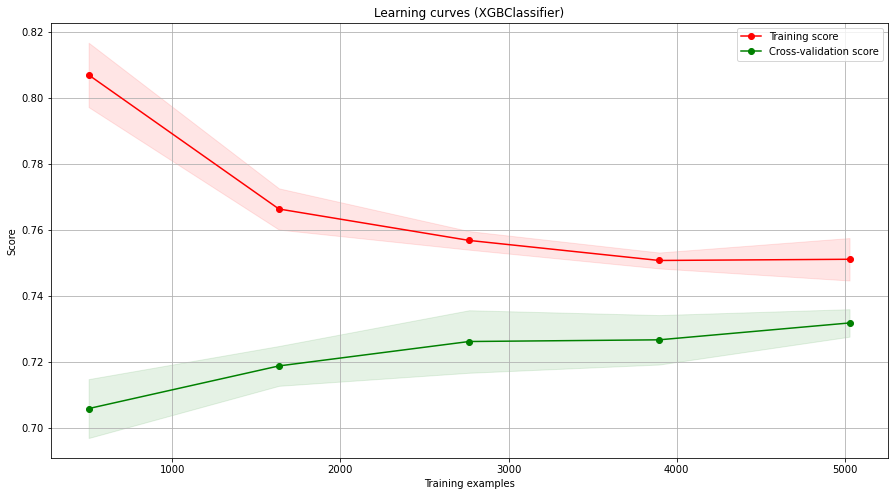

In [46]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

### Choosing a probability threshold for class definition

In [47]:
y_test_pred_probs = model_xgb.predict_proba(X_test)
y_test_pred_probs

array([[0.8424731 , 0.15752691],
       [0.45094162, 0.5490584 ],
       [0.6716577 , 0.32834235],
       ...,
       [0.99814683, 0.0018532 ],
       [0.69111764, 0.30888236],
       [0.48145032, 0.5185497 ]], dtype=float32)

In [48]:
print(inspect.getsource(show_proba_calibration_plots))

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, labe

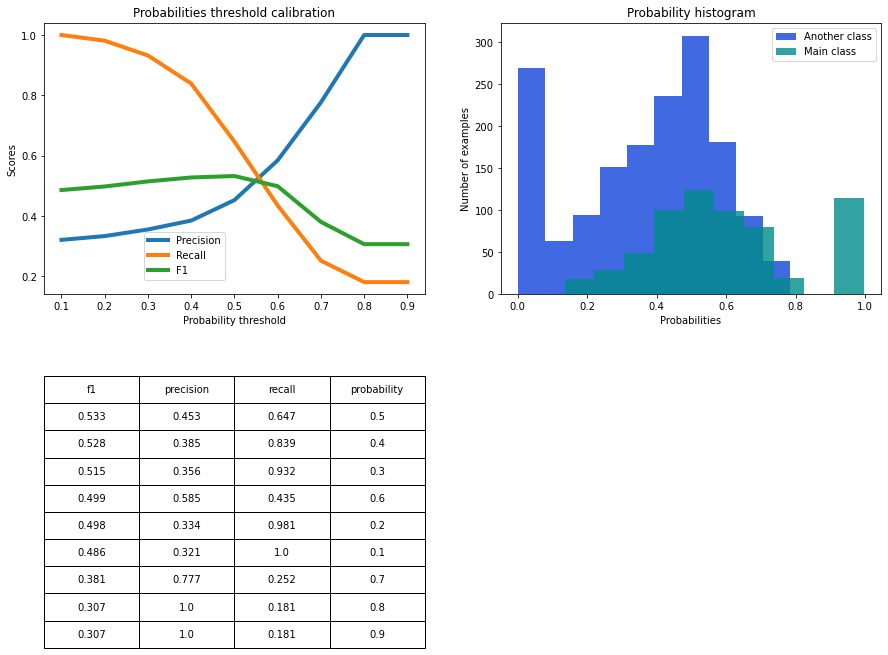

In [49]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

## Feature Importance

In [54]:
print(inspect.getsource(show_feature_importances))

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()



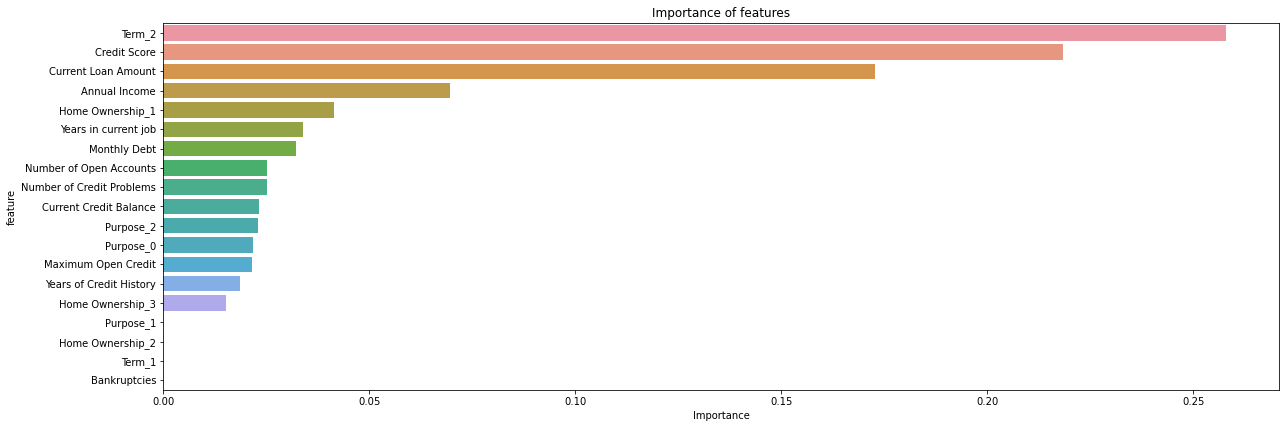

In [65]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_xgb.feature_importances_, get_top=15)

In [66]:
important_features_top

['Term_2',
 'Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Home Ownership_1',
 'Years in current job',
 'Monthly Debt',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Purpose_2',
 'Purpose_0',
 'Maximum Open Credit',
 'Years of Credit History',
 'Home Ownership_3']

## Final model

In [67]:
final_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=10
                              )
final_xgb.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(final_xgb,
               X_train_balanced[important_features_top],
               X_test[important_features_top],
               y_train_balanced,
               y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      3771
           1       0.72      0.77      0.75      3771

    accuracy                           0.74      7542
   macro avg       0.74      0.74      0.74      7542
weighted avg       0.74      0.74      0.74      7542

TEST

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1616
           1       0.44      0.64      0.53       634

    accuracy                           0.67      2250
   macro avg       0.64      0.66      0.64      2250
weighted avg       0.72      0.67      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1104  512
1                226  408


## Saving the final model

In [70]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_xgb, file)

## Catboost

In [85]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [87]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [88]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [89]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      3771
           1       0.55      0.68      0.61      1479

    accuracy                           0.75      5250
   macro avg       0.70      0.73      0.71      5250
weighted avg       0.77      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1616
           1       0.48      0.59      0.53       634

    accuracy                           0.71      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.73      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1212  404
1                257  377
CPU times: user 1.74 s, sys: 274 ms, total: 2.02 s
Wall time: 565 ms


### Reducing the degree of overfitting

In [90]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7, 
#                                 l2_leaf_reg=.5,
                                reg_lambda=0.5
                                )

model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      3771
           1       0.49      0.59      0.54      1479

    accuracy                           0.71      5250
   macro avg       0.66      0.68      0.67      5250
weighted avg       0.73      0.71      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1616
           1       0.47      0.58      0.52       634

    accuracy                           0.69      2250
   macro avg       0.64      0.66      0.65      2250
weighted avg       0.72      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1195  421
1                267  367


In [91]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [92]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7)

In [93]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [94]:
grid_search = model.randomized_search(params,
                                      X_train,
                                      y_train,
                                      n_iter=50,
                                      cv=cv,
                                      stratified=True,
                                      plot=True,
                                      refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6291743734
bestIteration = 117

0:	loss: 0.6291744	best: 0.6291744 (0)	total: 755ms	remaining: 37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6202121349
bestIteration = 31

1:	loss: 0.6202121	best: 0.6291744 (0)	total: 1.04s	remaining: 25s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6062439245
bestIteration = 2

2:	loss: 0.6062439	best: 0.6291744 (0)	total: 1.23s	remaining: 19.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6062439245
bestIteration = 2

3:	loss: 0.6062439	best: 0.6291744 (0)	total: 1.39s	remaining: 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6208164721
bestIteration = 57

4:	loss: 0.6208165	best: 0.6291744 (0)	total: 1.84s	remaining: 16.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6266128324
bestIteration = 43

5:	loss: 0.6266128	best: 0.6291744 (0)	total: 2.17s	remaining: 16s
S

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5952862499
bestIteration = 11

49:	loss: 0.5952862	best: 0.6534025 (37)	total: 17.9s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.6912911733
bestIteration = 1

Training on fold [1/3]

bestTest = 0.6243227132
bestIteration = 66

Training on fold [2/3]

bestTest = 0.6090621644
bestIteration = 3



In [95]:
grid_search

{'params': {'l2_leaf_reg': 3.1113924050632913},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
   

In [96]:
%%time

evaluate_preds(model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      3771
           1       0.62      0.77      0.68      1479

    accuracy                           0.80      5250
   macro avg       0.76      0.79      0.77      5250
weighted avg       0.82      0.80      0.81      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1616
           1       0.49      0.59      0.53       634

    accuracy                           0.71      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1217  399
1                257  377
CPU times: user 64.4 ms, sys: 3.52 ms, total: 67.9 ms
Wall time: 54.2 ms


### Selection of the optimal sample size, learning curve

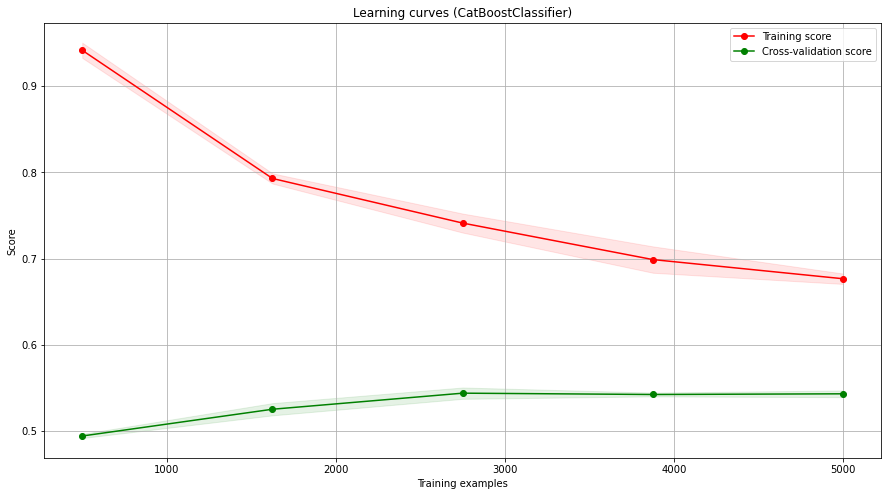

In [97]:
show_learning_curve_plot(model, X, y)

### Choosing a probability threshold for class definition

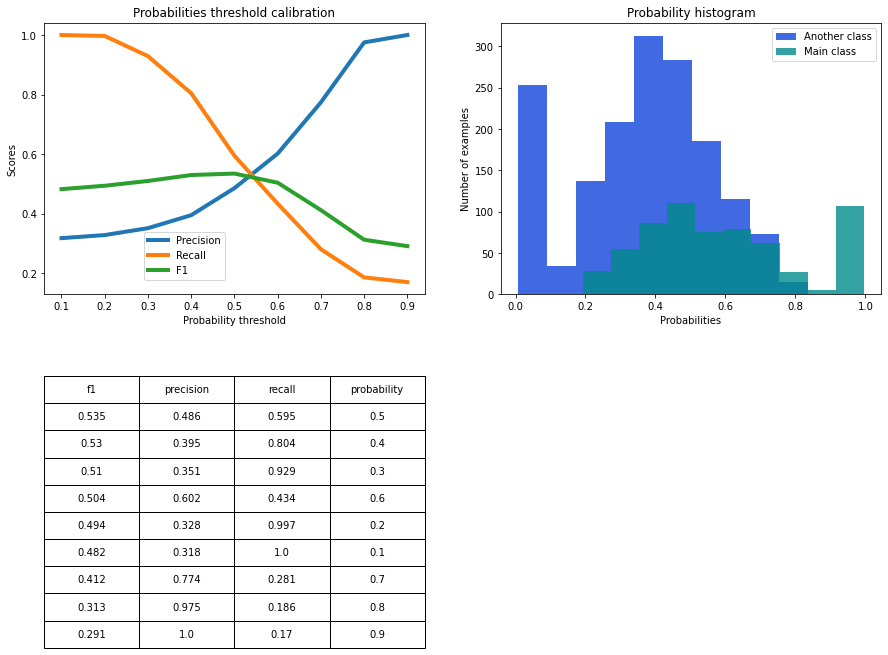

In [98]:
y_test_pred_probs = model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Feature Importance

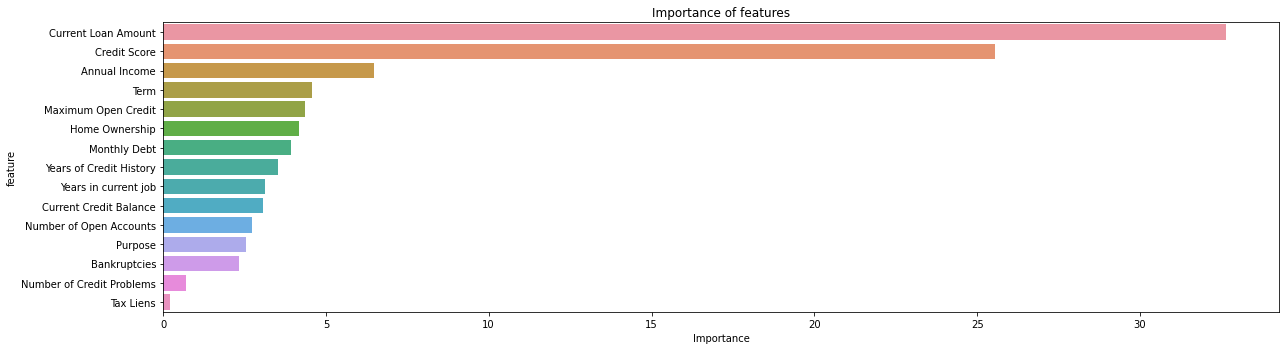

In [99]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=23)

In [100]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Term',
 'Maximum Open Credit',
 'Home Ownership',
 'Monthly Debt',
 'Years of Credit History',
 'Years in current job',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Purpose',
 'Bankruptcies',
 'Number of Credit Problems',
 'Tax Liens']

### final model

In [101]:
CAT_FEATURE_NAMES

['Home Ownership', 'Tax Liens', 'Bankruptcies', 'Purpose', 'Term']

In [102]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

['Bankruptcies', 'Tax Liens', 'Purpose', 'Home Ownership', 'Term']

In [103]:
%%time

frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':NEW_CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=300,
                                      max_depth=7,
                                      reg_lambda=0.5)

final_model.fit(X_train[important_features_top], y_train)

evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      3771
           1       0.64      0.77      0.70      1479

    accuracy                           0.81      5250
   macro avg       0.77      0.80      0.78      5250
weighted avg       0.83      0.81      0.82      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1616
           1       0.49      0.59      0.53       634

    accuracy                           0.71      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1221  395
1                260  374
CPU times: user 8.57 s, sys: 1.07 s, total: 9.64 s
Wall time: 1.72 s
